<div style="text-align:center"><span style="color:red; font-family:helvetica; font-size:2.0em;">Locomotion planning based on Divergent Component of Motion(DCM)</span></div>

In this project you will plan the Center of Mass (CoM) trajectory for a biped by using the Divergent Component of Motion (DCM) concept for locomotion on flat terrain. The code structure will include three blocks: the DCM Planner, Foot Trajectory Planner, and Inverse Kinematics. The only block that you need to implement is the DCM Planner. In other words, you only need to open and edit the `DCMTrajectoryGenerator.py`class and follow the comments that have been written in this class. The other parts have already been implemented. In the following you can go forward and run the jupyter notebook step by step until you reach to "Implementation of Planning DCM and CoM Trajectories" that you need to implement `DCMTrajectoryGenerator.py`. At the end you sould have the DCM and CoM vector (size 4320) that will be used in the inverse kinematics.

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Importing the required libraries</span></div>

In [1]:
#In the following we import the classes that we need for simulation
import time
import pybullet #pybullet simulator
import pybullet_data
import numpy as np # numpy library for matrix computatios
from FootTrajectoryGenerator import * # Foot trajectory generation Class
#You sould uncomment the following line after developing DCM part
from DCMTrajectoryGenerator import * #  DCM trajectory generation Class(will be implemented by students)
from RobotUtils import * # Class related to Inverse Kinematics 

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Preparing Pybullet environment</span></div>

In [2]:
#In the following we create an object of dynamic engine of pybullet and we connect it to the Pybullet GUI
phisycsClient = pybullet.connect(pybullet.GUI)
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
#In the following we load the urdf model of the robot and we specify the setting for the simulation
pybullet.resetSimulation()
planeID = pybullet.loadURDF("plane.urdf")
pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING,0)
pybullet.setGravity(0,0,-9.81)
atlas=robotID = pybullet.loadURDF("atlas/atlas_v4_with_multisense.urdf", [0,0,0.93],useFixedBase = 0)
pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_RENDERING,1)
pybullet.setRealTimeSimulation(0)

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Planning Feet Trajectories</span></div>

In [4]:


stepDuration =  0.9000000000000001 #We select 1.2 second as step duration(step duration=SS+DS)
stepLength = 0.3 #longitudinal distance between two sequential feet stepLength=stepStride/2, 

#In this part we will specify the steps position and duration and we will implement foot trajectory generation
doubleSupportDuration = 0.25 #We select 0.25 second as DS duration

pelvisHeight= 0.7 #Constant pelvis(CoM) height during walking
maximumFootHeight = 0.07 #The maximum height of swing foot during each step

FootPlanner = FootTrajectoryGenerator(stepDuration, doubleSupportDuration, maximumFootHeight) #We create an object of foot FootTrajectoryGenerator Class
stepWidth=0.12 #=lateralDistanceOfFeet/2

numberOfFootPrints=17
FootPrints=np.empty((numberOfFootPrints, 3))

#In the following we define the foot step positions(Ankle joint position projected on foot print)
for i in range(0,numberOfFootPrints):
    if(i%2==0):
        if(i==0):
            FootPrints[i][:]=[i*stepLength,stepWidth,0.0]
        elif(i==numberOfFootPrints-1):
            FootPrints[i][:]=[(i-2)*stepLength,stepWidth,0.0]            
        else:
            FootPrints[i][:]=[(i-1)*stepLength,stepWidth,0.0]
    else:
        FootPrints[i][:]=[(i-1)*stepLength,-stepWidth,0.0]
            

FootPlanner.setFootPrints(FootPrints)#We set the foot step positions
FootPlanner.generateTrajectory() #We generate the foot trajectory 
leftFootTrajectory = np.array(FootPlanner.getLeftFootTrajectory())
rightFootTrajectory = np.array(FootPlanner.getRightFootTrajectory())

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Plot Feet Trajectories</span></div>

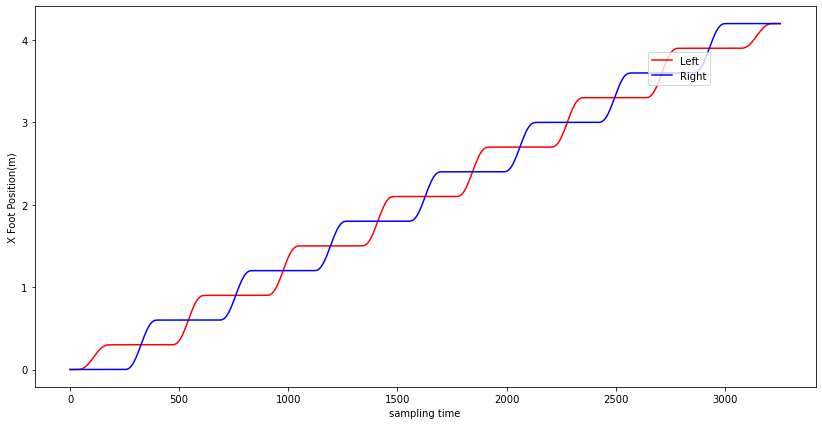

<Figure size 432x288 with 0 Axes>

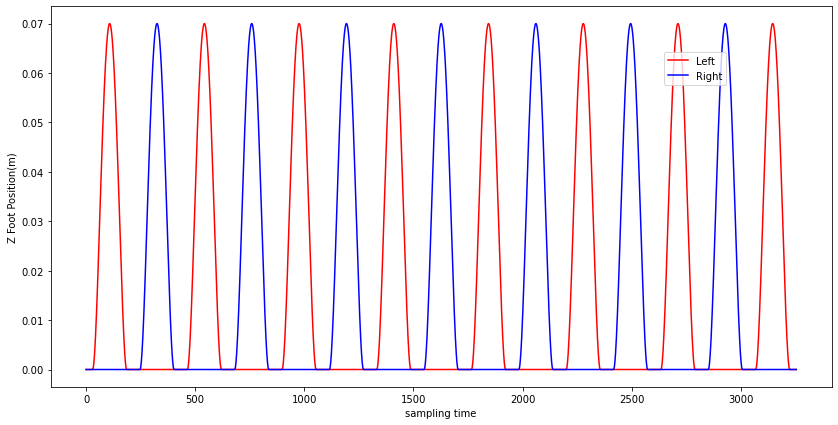

<Figure size 432x288 with 0 Axes>

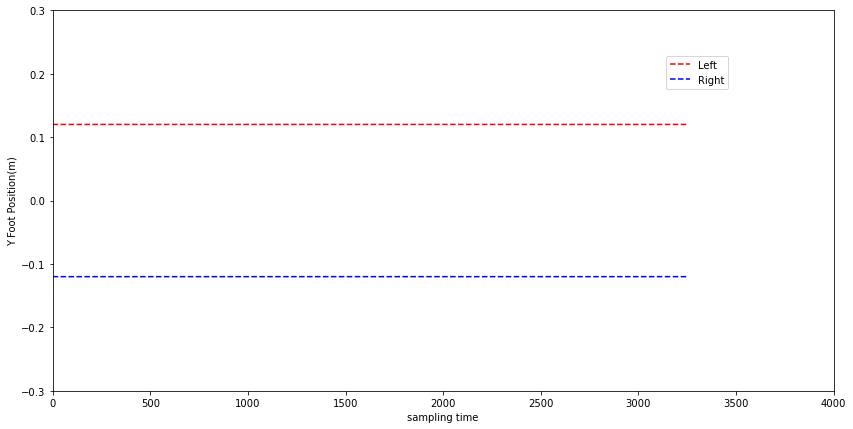

<Figure size 432x288 with 0 Axes>

In [5]:
tempL=np.array(FootPlanner.lFoot_)
tempR=np.array(FootPlanner.rFoot_)
figg1, (ax1) = plt.subplots(figsize = (14, 7))
ax1.plot(tempL[:,0],'r',label="Left")
ax1.plot(tempR[:,0],'b',label="Right")
ax1.set_xlabel('sampling time')
ax1.set_ylabel('X Foot Position(m)')
figg1.legend(bbox_to_anchor=(0.8, 0.8))
plt.show()
plt.savefig('../plots/x_foot_pos_time.pdf')

figg2, (ax3) = plt.subplots(figsize = (14, 7))
ax3.plot(tempL[:,2],'red',label="Left")
ax3.plot(tempR[:,2],'blue',label="Right")
ax3.set_xlabel('sampling time')
ax3.set_ylabel('Z Foot Position(m)')
figg2.legend(bbox_to_anchor=(0.8, 0.8))
plt.show() 
plt.savefig('../plots/z_foot_pos_time.pdf')

figg3, (ax2) = plt.subplots(figsize = (14, 7))
ax2.plot(tempL[:,1],'--r',label="Left")
ax2.plot(tempR[:,1],'--b',label="Right")
ax2.set_xlabel('sampling time')
ax2.set_ylabel('Y Foot Position(m)')
ax2.set(xlim=(-0.2, 4000), ylim=(-0.3, 0.3))
figg3.legend(bbox_to_anchor=(0.8, 0.8))
plt.show() 
plt.savefig('../plots/y_foot_pos_time.pdf')

<div style="text-align:center"><span style="color:black; font-family:helvetica; font-size:1.7em;"Locomotion Planning based on DCM</span></div>

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">DCM and CoM Motion Planning</span></div>

In this section we will plan the DCM and CoM trajectory following the method presented in:
"Englsberger, Johannes, Christian Ott, and Alin Albu-Schäffer. "Three-dimensional bipedal walking control based on divergent component of motion." IEEE Transactions on Robotics 31.2 (2015): 355-368.(254)"


Here we elaborate the equations in detail. For the inverted pendulum equation we have:
<img src="img/invertedpendulum.png" width=300 height=300 />

\begin{equation}
\ddot x_c=\omega^2(x_c-r_{CoP})  \; \; \; \; \; \; (1)
\end{equation}

This equation has been derived by finding the momentum around the Center of Pressure (COP, also ZMP) that is equal to zero with the dynamic balancing condition. Then we define the DCM dynamics as follows:

$$ \xi=x_c + \frac{\dot x_c}{\omega} \; \; \; \; \; \; (2)$$

where $\xi $ is the DCM, $x_c$ is the CoM position, and $\omega=\sqrt{\frac{g}{z_c}}$ is the natural frequency of the DCM dynamics. By reordering (2), we can derive the CoM dynamics:

$$\dot x_c=\omega(\xi-x_c) \; \; \; \; \; \; (3)$$
 This shows that the CoM has stable first-order dynamics (i.e. it follows the DCM). By differentiating (2) and inserting (3) and (1), we can write the DCM dynamics:
$$\dot \xi=\omega(\xi-r_{CoP}) \; \; \; \; \; \; (4) $$


The DCM has unstable first-order dynamics (it is “pushed” by the CoP), whereas the CoM follows the DCM with stable first-order dynamics. 

To find the desired DCM trajectory from given constant $CoP$s, the solution for the DCM Dynamics is:

$$\xi(t)=r_{cop}+(\xi_{0}-r_{cop})e^{\omega t} \; \; \; \; \; \; (5) $$

where $\xi_0 =\xi(0)$. The “internal” timestep $t$ is reset at the beginning of each step, i.e., $t \in [0,T] $ ($T$ is the duration of the step). In the following, we will present a step by step method for DCM and CoM motion planning based on (5). 


1. First, we select the foot step position and step duration based on the desired velocity and considering the kinematic and dynamic constraint of the robot:  

.
<img src="img/00.png" width=300 height=300 />
.

2. Place the desired CoP in a fixed location inside of the foot print. This condition guarantees dynamic balance during locomotion:

.
<img src="img/0.png" width=300 height=300 />
.


3. We place the last DCM position on the last CoP (Capturability constraint). For planning, we assume that the DCM will come to a stop over the final previewed foot position, i.e., $\xi_{eos,N-1}=r_{cop,N}$ (where $eos$ is end-of-step):

.
<img src="img/1.png" width=300 height=300 />
.


4.  By having the constant desired $CoP$ positions for each step and the last DCM Position (located on the CoP), we find the desired DCM locations at the end of each step via recursion using equation (5):

$$\xi_{eos,i}=r_{cop,i}+(\xi_{ini,i}-r_{cop,i})e^{\omega T} \; \; \; \; \; \; (6)$$

$$\xi_{ini,i}=r_{cop,i}+(\xi_{eos,i}-r_{cop,i})e^{-\omega T} \; \; \; \; \; \; (7) $$
$$\xi_{eos,i-1}=\xi_{ini,i}\; \; \; \; \; \; (8)$$

.
<img src="img/2.png" width=400 height=400 />
.

where  $\xi_{ini,i}$ is the ith initial desired DCM.
 

 
5. Now based on (7) and (5), the reference trajectories for the DCM position (for single support (SS) phase) of the $i$th step can be computed as:$$\xi_i(t)=r_{cop,i}+(\xi_{eos,i}-r_{cop,i})e^{\omega (t-T)}\; \; \; \; \; \; (9)$$ The “internal” step time $t$ is reset at the beginning of each step, i.e., $t \in [0,T] $ ($T$ is the duration of the step).

.
<img src="img/3.png" width=400 height=400 />
.


6. As planne so far, the DCM trajectory only considers single support phases (and instantaneous transitions between them), so there is a drawback of a discontinuous CoP reference and thus discontinuous desired external forces at the support transitions. This leads to discontinuities in the commanded joint torques, which can be infeasible for a physical robot due to its limited actuator dynamics. This motivates the derivation of DCM trajectories that lead to continuous CoP transitions. For a desired DCM position and velocity, the corresponding CoP is obtained from (4) as:$$r_{CoP} = \xi-\frac{\dot \xi} {\omega} \; \; \; \; \; \; (10)$$This means that a reference trajectory with continuous DCM position and velocity results in a continuous CoP trajectory and external force trajectories. This motivates the use of a third-order polynomial interpolation to “round” the edges of the preliminary DCM reference trajectory (corresponding to smooth transition during double support (DS) phase). Given a desired DS duration  $t_{DS}$, the idea is to compute two points$$\xi_{iniDS,i}=r_{cop,i-1}+(\xi_{ini,i}-r_{cop,i-1})e^{-\omega \Delta t_{DS,ini}} \; \; \; \; \; \; (11) $$$$\xi_{eoDS,i}=r_{cop,i}+(\xi_{ini,i}-r_{cop,i})e^{\omega \Delta t_{DS,end}}\; \; \; \; \; \; (12)$$where $iniDS$ stands for “initial double support” and $eoDS$ stands for “end of double support" on the preliminary DCM trajectory, where the duration for DCM before support transition and after support transition would be:
$$ \Delta t_{DS,ini}=\alpha _{DS,ini} t_{DS}\; \; \; \; \; \; (13)$$
$$ \Delta t_{DS,end}=(1-\alpha _{DS,ini} ) t_{DS}\; \; \; \; \; \; (14)$$

.
<img src="img/4.png" width=400 height=400 />
.

Note: The first step is a little different and we have:
$$\xi_{iniDS,1}=\xi_{ini,1} \; \; \; \; \; \; (11b) $$

$$\xi_{eoDS,1}=r_{cop,1}+(\xi_{ini,1}-r_{cop,1})e^{\omega \Delta t_{DS,end}}\; \; \; \; \; \; (12b)$$


7. We use a cubic interpolation for finding the DCM trajectory in double support (DS) phase. Replace the DCM planned trajectory  for the DS with the corresponding part  that was for single support (the double support(DS)). In this study, we choose the parameter $\alpha = 0.5$. $\xi_{iniDS,i}$ and $\xi_{eoDS,i}$ (and the corresponding DCM velocities) are used as boundary conditions for the interpolation polynomial. For initial and final DCM position and velocity boundary conditions, a polynomial parameter matrix can be found as:$$P = \begin{bmatrix}
   \frac{2}{T_{{DS}}^3} &  \frac{1}{T_{DS}^2} &- \frac{2}{T_{DS}^3} &  \frac{1}{T_{DS}^2} \\
  -\frac{3}{T_{{DS}}^2} &  -\frac{2}{T_{DS}} & \frac{3}{T_{DS}^2} &  -\frac{1}{T_{DS}}  \\
  0 &1 & 0&  0 \\
    1 &0 &0  & 0
    \end{bmatrix}\begin{bmatrix}
  \xi_{iniDS,i}\\
\dot \xi_{iniDS,i} \\
  \xi_{eosDS,i}\\
 \dot \xi_{eosDS,i}
\end{bmatrix} \; \; \; \; \; \; (15)$$where $T_{DS}$ denotes the total duration of the transition. With $P$, for any time $t \in [0,T_{DS}] $ the DCM position and velocity can be computed as$$   \begin{bmatrix}
  \xi(t) \\
 \dot \xi(t)
\end{bmatrix}  =  \begin{bmatrix}
  t^3&  t^2 & t &  1 \\
    3t^2 &2 t&1  & 0
    \end{bmatrix}
P \; \; \; \; \; \; (16)$$We just replace the part of the DCM trajectory for DS phase with the corresponding part of the preliminary planned DCM trajectory that was only based on single support.

.
<img src="img/5.png" width=400 height=400 />
. 
 
In the above figure, the green line is a preliminary DCM trajectory based only on single support phase, and the blue line is the final DCM trajectory that also includes double support phase. After having the full DCM trajectory, we can find the CoM trajectory by substituting the current DCM and CoM into equation (3) and then calculating a numerical integration for finding CoM position.






<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Implementation of Planning DCM and CoM Trajectories</span></div>

In [6]:
CoPOffset=np.array([0,0.016]) #Offset between CoP and footprint position(Ankle position) 

DCMPlanner = DCMTrajectoryGenerator(pelvisHeight, stepDuration, doubleSupportDuration)#We create an object of foot DCMTrajectoryGenerator Class

CoPPositions=np.empty((DCMPlanner.numberOfSteps+1, 3))#Initialization of the CoP array

for i in range(0,DCMPlanner.numberOfSteps+1):
    if(i%2!=0):
        CoPPositions[i][:]=[(i)*stepLength-CoPOffset[0],stepWidth-CoPOffset[1],0.0]
        if(i==1):
            CoPPositions[i][:]=[(i)*stepLength,stepWidth-CoPOffset[1],0.0]
    else:
        CoPPositions[i][:]=[(i)*stepLength-CoPOffset[0],-stepWidth+CoPOffset[1],0.0]
        if(i==0):
            CoPPositions[i][:]=[(i)*stepLength,-stepWidth+CoPOffset[1],0.0]

DCMPlanner.setCoP(CoPPositions)#We set the desired CoP positions

DCMPlanner.setFootPrints(FootPrints)#We set the foot steps positions

DCMTrajectory = DCMPlanner.getDCMTrajectory()#At the end of DCM Planning the size of DCM vector should be 4320


In [7]:


DCMPlanner = DCMTrajectoryGenerator(pelvisHeight, stepDuration, doubleSupportDuration)#We create an object of foot DCMTrajectoryGenerator Class
CoPPositions=np.empty((DCMPlanner.numberOfSteps+1, 3))#Initialization of the CoP array

#In the following we define the foot step positions
for i in range(0,DCMPlanner.numberOfSteps+1):
    if(i%2!=0):
        CoPPositions[i][:]=[(i)*stepLength-CoPOffset[0],stepWidth-CoPOffset[1],0.0]
        if(i==1):
            CoPPositions[i][:]=[(i)*stepLength,stepWidth-CoPOffset[1],0.0]
    else:
        CoPPositions[i][:]=[(i)*stepLength-CoPOffset[0],-stepWidth+CoPOffset[1],0.0]
        if(i==0):
            CoPPositions[i][:]=[(i)*stepLength,-stepWidth+CoPOffset[1],0.0]
        
DCMPlanner.setCoP(CoPPositions)#We set the desired CoP positions
DCMPlanner.setFootPrints(FootPrints)#We set the foot steps positions
DCMTrajectory = DCMPlanner.getDCMTrajectory()#At the end of DCM Planning the size of DCM vector should be 4320
initialCoM = np.array([0.0,0.0,DCMPlanner.CoMHeight])
comTrajectory = DCMPlanner.getCoMTrajectory(initialCoM)
DCMPlanner.calculateCoPTrajectory()

DCMPlanner.alpha = 0.5;

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Plot DCM and CoM Trajectories</span></div>

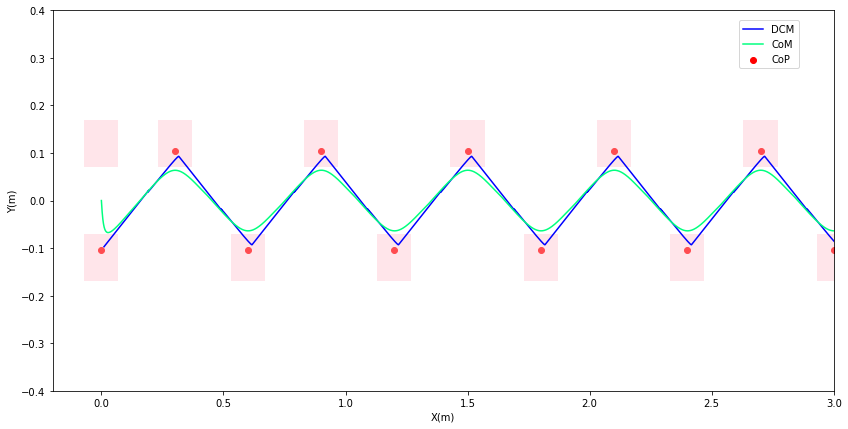

<Figure size 432x288 with 0 Axes>

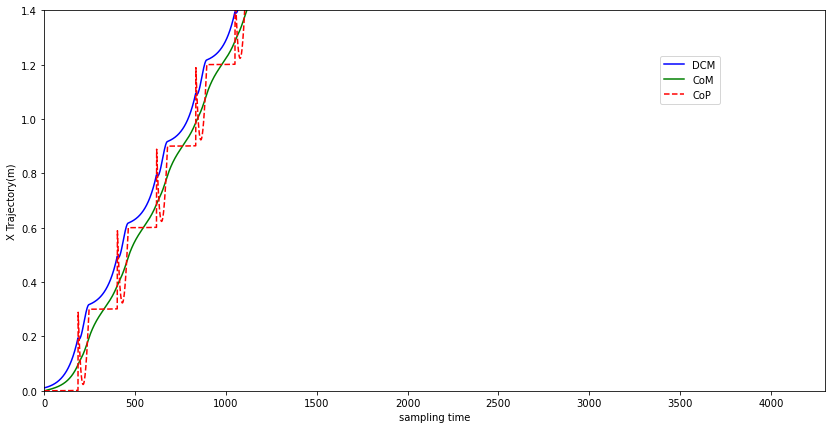

<Figure size 432x288 with 0 Axes>

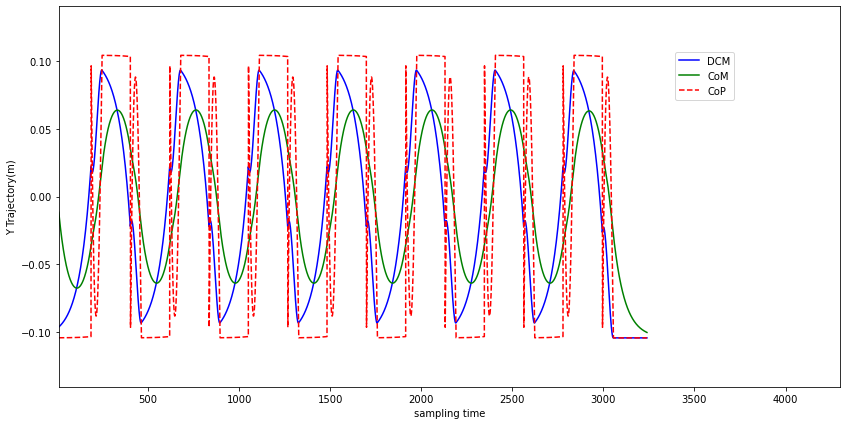

In [8]:
fig4, (ax4) = plt.subplots(figsize = (14, 7))
footWidth=0.1
footLength=0.14
for i in range(0,np.size(DCMPlanner.footPrints,0)):
    rect = plt.Rectangle((DCMPlanner.footPrints[i,0]-footLength/2, DCMPlanner.footPrints[i,1]-footWidth/2),footLength, footWidth,
           facecolor="pink", alpha=0.4) 
    ax4.add_patch(rect)
ax4.set(xlim=(-0.2, 3), ylim=(-0.4, 0.4))
ax4.scatter(DCMPlanner.CoP[:,0],DCMPlanner.CoP[:,1],c='red',label="CoP")
ax4.set_xlabel('X(m)')
ax4.set_ylabel('Y(m)')
ax4.plot(DCMPlanner.DCM[:,0],DCMPlanner.DCM[:,1],'blue',label="DCM")
ax4.plot(DCMPlanner.CoM[:,0],DCMPlanner.CoM[:,1],'springgreen',label="CoM")
fig4.legend(bbox_to_anchor=(0.87, 0.87))
plt.show()
plt.savefig('../plots/x_y_dcm_foot_steps.pdf')


figg5, (ax5) = plt.subplots(figsize = (14, 7))
ax5.plot(DCMPlanner.DCM[:,0],'b',label="DCM")
ax5.plot(DCMPlanner.CoM[:,0],'g',label="CoM")
ax5.plot(DCMPlanner.CoPTrajectory[:,0],'--r',label="CoP")
ax5.set_xlabel('sampling time')
ax5.set_ylabel('X Trajectory(m)')
ax5.set(xlim=(-0.0,4300), ylim=(-0.0, 1.4))
figg5.legend(bbox_to_anchor=(0.8, 0.8))
plt.show() 
plt.savefig('../plots/dcm_foot_steps.pdf')
plt.savefig('../plots/x_dcm_foot_steps.pdf')

figg6, (ax6) = plt.subplots(figsize = (14, 7))
ax6.plot(DCMPlanner.DCM[:,1],'b',label="DCM")
ax6.plot(DCMPlanner.CoM[:,1],'g',label="CoM")
ax6.plot(DCMPlanner.CoPTrajectory[:,1],'--r',label="CoP")
ax6.set_ylabel('Y Trajectory(m)')
ax6.set_xlabel('sampling time')
ax6.set(xlim=(10,4300), ylim=(-0.14, 0.14))
figg6.legend(bbox_to_anchor=(0.8, 0.8))
plt.savefig('../plots/z_dcm_foot_steps.pdf')
plt.show() 
 

<div style="text-align:center"><span style="color:lightblue; font-family:helvetica; font-size:1.7em;">Implementing Trajectories on the Robot</span></div>


In [9]:
AtlasUtils = RobotUtils()#This object is responsible for inverse kinematics

#Preparing the constant joints position for the upper-body joints
leftArmPositions=[-0.2,-1.7,0.3,-0.3,0.0,0.0,0.0]
rightArmPositions=[ 0.2, 1.7,0.3, 0.3,0.0,0.0,0.0]
bodyPositions = [0.0,0.0,0.0,0.0]
leftArmIndex = [3,4,5,6,7,8,9]
rightArmIndex= [11,12,13,14,15,16,17]
bodyIndex = [0,1,2,10]
leftLegIndex=[18,19,20,21,22,23]
rightLegIndex=[24,25,26,27,28,29]
jointsIndex= np.zeros(30)
jointsPositions= np.zeros(30)
jointsIndex[0:4]=bodyIndex
jointsIndex[4:11]=rightArmIndex
jointsIndex[11:18]=leftArmIndex
jointsIndex[18:24]=rightLegIndex
jointsIndex[24:30]=leftLegIndex
jointsPositions[0:4]=bodyPositions
jointsPositions[4:11]=rightArmPositions
jointsPositions[11:18]=leftArmPositions

GRAVITY = 9.81
cost_of_transport = []

for i in range(1000):  #1000 sampling time will be allocated for the initialization of the robot position
    lowerBodyJoints= AtlasUtils.doInverseKinematics([0.0,0.0,0.9 - (i/1000)* (0.9-DCMPlanner.CoMHeight)], np.eye(3),[0.0,0.13,0.0], np.eye(3),[0.0, -0.13,0.0], np.eye(3))
    jointsPositions[24:30] = lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    pybullet.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex,
                                controlMode=pybullet.POSITION_CONTROL,
                                targetPositions = jointsPositions)
    pybullet.stepSimulation()
    time.sleep(0.0002)
    
time.sleep(1)#Just wait for a second

#Solving the inverse kinematic and sending the joints position command to the robot
for i in range(int((DCMPlanner.numberOfSamplesPerSecond) * CoPPositions.shape[0] * DCMPlanner.stepDuration)):
    lowerBodyJoints = AtlasUtils.doInverseKinematics(comTrajectory[i], np.eye(3),leftFootTrajectory[i], np.eye(3),rightFootTrajectory[i], np.eye(3))
    jointsPositions[24:30] = lowerBodyJoints[6:12]
    jointsPositions[18:24] = lowerBodyJoints[0:6]
    pybullet.setJointMotorControlArray(bodyIndex=robotID,
                                jointIndices=jointsIndex,
                                controlMode=pybullet.POSITION_CONTROL,
                                targetPositions = jointsPositions)
    
    
    
    #The following part, at every 14 sampling period, will plot the foot and pelvis trajectory in pybullet 
    if(i>14 and i%14==0):
        pybullet.addUserDebugLine(comTrajectory[i-14],comTrajectory[i],[0,0.9,0.0],4,140)
        pybullet.addUserDebugLine(leftFootTrajectory[i-14],leftFootTrajectory[i],[1.0,0.0,0.8],4,140)
        pybullet.addUserDebugLine(rightFootTrajectory[i-14],rightFootTrajectory[i],[0.1,0.9,0.8],4,140)
    pybullet.stepSimulation()

    current_motor_torques = np.array([x[3] for x in pybullet.getJointStates(bodyUniqueId=robotID, jointIndices=jointsIndex)])
    current_motor_velocities = np.array([x[1] for x in pybullet.getJointStates(bodyUniqueId=robotID, jointIndices=jointsIndex)])

    current_base_velocitites = np.array([x[0] for x in pybullet.getBaseVelocity(bodyUniqueId=robotID)])[0] # get linear x vel
    #current_mass = np.array([x for x in pybullet.getDynamicsInfo(bodyUniqueId=robotID, linkIndex=29)])[0] # get base weight

    # get mass at each link and then total mass
    total_mass = 0
    for i in range(len(jointsIndex)):
        current_mass = np.array([x for x in pybullet.getDynamicsInfo(bodyUniqueId=robotID, linkIndex=i)])[0]
        total_mass += current_mass 

    current_power = np.abs(current_motor_torques).dot(np.abs(current_motor_velocities))
    current_cost_of_transport = np.abs(current_power / (total_mass * GRAVITY * current_base_velocitites))
    cost_of_transport.append(current_cost_of_transport)


C:\Users\qiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [10]:
CoT = np.sum(cost_of_transport) / len(cost_of_transport)
print('Cost of Transport:', CoT)

Cost of Transport: 0.7142338457310213


In [11]:
for i in range(1,1000):
    pybullet.stepSimulation()
pybullet.disconnect()

In [12]:
"""
time = np.arange(len(cost_of_transport))
cost_of_transport = np.array(cost_of_transport)
bodyCost = []

for i, cost in enumerate(cost_of_transport):
    current_bodyCost = 0
    current_bodyCost = np.sum(cost_of_transport[i][bodyIndex])
    bodyCost.append(current_bodyCost)

plt.plot(time, bodyCost)
plt.title('Cost of Transport Body vs. Time')
plt.xlabel('Time')
plt.ylabel('Cost of Transport Body')
"""

"\ntime = np.arange(len(cost_of_transport))\ncost_of_transport = np.array(cost_of_transport)\nbodyCost = []\n\nfor i, cost in enumerate(cost_of_transport):\n    current_bodyCost = 0\n    current_bodyCost = np.sum(cost_of_transport[i][bodyIndex])\n    bodyCost.append(current_bodyCost)\n\nplt.plot(time, bodyCost)\nplt.title('Cost of Transport Body vs. Time')\nplt.xlabel('Time')\nplt.ylabel('Cost of Transport Body')\n"

Questions:

1-Based on equation (5) which physical parameters will affect the rate of divergence of DCM dynamics?

2-In the DCM motion planning how we garantee to have a Dynamic Balancing?

3-If we garantee to have dynamic balancing why the robot is not able to walk without parameter tuning?

4-Which parameters you found useful for tunning to have a stable locomotion and whats the value of those parameters?

5-Find the cost of transport for this walking planner and do a comparison with the previous matlab homework?
What are the source of difference?

6-Change the step position and duration in "Planning Feet Trajectories" section, to have a faster locomotion. what's the fastest walking speed that you have achived and what are the corresponding parameters?